# Imports and configs

In [1]:
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import roc_curve, auc
from torch.utils.data import DataLoader, Dataset
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
import albumentations as A
import seaborn as sns
from tqdm import tqdm
from PIL import Image
import torch.nn as nn
import pandas as pd
import numpy as np
import warnings
import h5py
import torch
import random
import timm
import io
import os
import gc

warnings.filterwarnings('ignore')

In [2]:
class CFG:
    train_metadata_path = '/kaggle/input/isic-2024-challenge/train-metadata.csv'
    test_metadata_path = '/kaggle/input/isic-2024-challenge/test-metadata.csv'
    train_img_path = '/kaggle/input/isic-2024-challenge/train-image.hdf5'
    test_img_path = '/kaggle/input/isic-2024-challenge/test-image.hdf5'
    sample_sub_path = '/kaggle/input/isic-2024-challenge/sample_submission.csv'
    checkpoint_path = '/kaggle/working/checkpoints'

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    max_epochs = 50
    learning_rate = 1e-4
    train_batch_size = 32
    val_batch_size = 64
    n_folds = 6
    seed = 892
    model_name = "resnet50"
    es_patience = 10

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(CFG.seed)

# Loading and splitting the datasets

In [4]:
train_metadata = pd.read_csv(CFG.train_metadata_path)

positives = train_metadata[train_metadata.target == 1]
negatives = train_metadata[train_metadata.target == 0]
train_metadata = pd.concat([positives, negatives.sample(n=20 * len(positives), random_state=CFG.seed)])
train_metadata = train_metadata.sample(frac=1, random_state=CFG.seed).reset_index(drop=True)

In [5]:
sgkf = StratifiedGroupKFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True)
split = sgkf.split(train_metadata, train_metadata.target, groups=train_metadata.patient_id)
for i, (_, val_index) in enumerate(split):
    train_metadata.loc[val_index, 'fold'] = i

In [6]:
train_metadata2 = pd.read_csv(CFG.train_metadata_path)

sgkf = StratifiedGroupKFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True)
split = sgkf.split(train_metadata2, train_metadata2.target, groups=train_metadata2.patient_id)
for i, (_, val_index) in enumerate(split):
    train_metadata2.loc[val_index, 'fold'] = i

# Creating a custom image dataset

In [7]:
class ISICDataset(Dataset):
    def __init__(self, data_path, metadata, transform=None):
        self.data = h5py.File(data_path, 'r')
        self.metadata = metadata
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        img_name = self.metadata.iloc[idx]['isic_id']
        image = np.array(self.data[img_name])
        image = np.array(Image.open(io.BytesIO(image)), dtype=np.float32)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        if 'target' in self.metadata.columns:
            label = int(self.metadata['target'].iloc[idx])
            return image, label
        else:
            return image, 0

In [8]:
# Reference: https://www.kaggle.com/code/motono0223/isic-pytorch-training-baseline-image-only

transforms = {
    "train": A.Compose([
        A.Resize(224, 224),
        A.RandomRotate90(p=0.5),
        A.Flip(p=0.5),
        A.Downscale(p=0.25),
        A.ShiftScaleRotate(
            shift_limit=0.1,
            scale_limit=0.15,
            rotate_limit=60,
            p=0.5
        ),
        A.HueSaturationValue(
            hue_shift_limit=0.2,
            sat_shift_limit=0.2,
            val_shift_limit=0.2,
            p=0.5
        ),
        A.RandomBrightnessContrast(
            brightness_limit=(-0.1, 0.1),
            contrast_limit=(-0.1, 0.1),
            p=0.5
        ),
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
            max_pixel_value=255.0,
            p=1.0
        ),
        ToTensorV2()], p=1.),

    "val": A.Compose([
        A.Resize(224, 224),
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
            max_pixel_value=255.0,
            p=1.0
        ),
        ToTensorV2()], p=1.)
}

# Customizing the image model

In [9]:
class ResNet50(nn.Module):
    def __init__(self, model_name, num_classes=2, pretrained=True):
        super(ResNet50, self).__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained, in_chans=3)
        self.model.reset_classifier(num_classes=num_classes, global_pool='avg')

    def forward(self, x):
        return self.model(x)

# Creating a trainer class

In [10]:
class Trainer:
    def __init__(
        self,
        device,
        model,
        criterion,
        optimizer,
        scheduler,
        train_dataloader,
        val_dataloader,
        checkpoint_path,
        fold_idx,
        es_patience
    ):
        self.device = device
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.checkpoint_path = checkpoint_path
        self.best_pauc = 0.0
        self.best_model_path = None
        self.fold_idx = fold_idx
        self.es_patience = es_patience
        self.create_checkpoint_path()

    def create_checkpoint_path(self):
        if not os.path.exists(self.checkpoint_path):
            os.makedirs(self.checkpoint_path)

    @staticmethod
    def p_roc_auc_score(y_true, y_preds, min_tpr: float = 0.80):
        v_gt = abs(np.asarray(y_true)-1)
        v_pred = -1.0 * np.asarray(y_preds)
        max_fpr = abs(1-min_tpr)
        fpr, tpr, _ = roc_curve(v_gt, v_pred, sample_weight=None)
        if max_fpr is None or max_fpr == 1:
            return auc(fpr, tpr)
        if max_fpr <= 0 or max_fpr > 1:
            raise ValueError("Expected min_tpr in range [0, 1), got: %r" % min_tpr)
        stop = np.searchsorted(fpr, max_fpr, "right")
        x_interp = [fpr[stop - 1], fpr[stop]]
        y_interp = [tpr[stop - 1], tpr[stop]]
        tpr = np.append(tpr[:stop], np.interp(max_fpr, x_interp, y_interp))
        fpr = np.append(fpr[:stop], max_fpr)
        partial_auc = auc(fpr, tpr)
        return partial_auc

    def train(self, current_epoch_nr):
        self.model.train()

        num_batches = len(self.train_dataloader)

        running_loss = 0.0
        total = 0

        preds = []
        targets = []

        loop = tqdm(self.train_dataloader, total=num_batches)
        for batch in loop:
            x, y = batch
            x, y = x.to(self.device), y.to(self.device)

            self.optimizer.zero_grad()

            y_hat = self.model(x)
            pred_probs = F.softmax(y_hat, dim=1)

            preds.extend(pred_probs[:, 1].detach().cpu().numpy())
            targets.extend(y.detach().cpu().numpy())

            loss = self.criterion(y_hat, y)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item() * x.size(0)
            total += y.size(0)

            loop.set_description(f'Epoch {current_epoch_nr}')
            loop.set_postfix(train_loss=round(running_loss / total, 6))

            if self.scheduler is not None:
                self.scheduler.step()

        train_pauc = self.p_roc_auc_score(targets, preds)
        train_loss = running_loss / num_batches

        return train_pauc, train_loss

    def evaluate(self, current_epoch_nr):
        self.model.eval()

        num_batches = len(self.val_dataloader)

        running_loss = 0.0
        total = 0

        preds = []
        targets = []

        with torch.no_grad():
            loop = tqdm(self.val_dataloader, total=num_batches)
            for batch in loop:
                x, y = batch
                x, y = x.to(self.device), y.to(self.device)

                self.optimizer.zero_grad()

                y_hat = self.model(x)
                pred_probs = F.softmax(y_hat, dim=1)

                preds.extend(pred_probs[:, 1].detach().cpu().numpy())
                targets.extend(y.detach().cpu().numpy())

                loss = self.criterion(y_hat, y)
                running_loss += loss.item() * x.size(0)
                total += y.size(0)

                loop.set_description(f'Epoch {current_epoch_nr}')
                loop.set_postfix(val_loss=round(running_loss / total, 6))

        val_pauc = self.p_roc_auc_score(targets, preds)
        val_loss = running_loss / num_batches

        if val_pauc > self.best_pauc:
            self.es_patience = CFG.es_patience
            if self.best_pauc != 0.0:
                print(f'New best model found: pAUC = {val_pauc:.6f} (previous best: {self.best_pauc:.6f})')
            self.best_pauc = val_pauc
            checkpoint_name = f'fold_{self.fold_idx}_epoch_{current_epoch_nr}_pauc_{round(val_pauc, 6)}.pth'

            for file in os.listdir(self.checkpoint_path):
                if file.startswith(f'fold_{self.fold_idx}_epoch_'):
                    os.remove(os.path.join(self.checkpoint_path, file))

            torch.save(
                self.model.state_dict(),
                os.path.join(self.checkpoint_path, checkpoint_name)
            )
            self.best_model_path = os.path.join(
                self.checkpoint_path, checkpoint_name)

        else:
            self.es_patience -= 1
            if self.es_patience == 0:
                print(f'Early stopping triggered at epoch {current_epoch_nr}. Best pAUC = {self.best_pauc:.6f}')
                return val_pauc, val_loss, True

        return val_pauc, val_loss, False

    def predict(self, dataloader):
        model = self.model.to(self.device)
        model.load_state_dict(torch.load(self.best_model_path))
        model.eval()

        preds = []
        with torch.no_grad():
            loop = tqdm(dataloader, total=len(dataloader))
            for batch in loop:
                x, _ = batch
                x = x.to(self.device)
                y_hat = model(x)
                pred_probs = F.softmax(y_hat, dim=1)
                preds.extend(pred_probs.detach().cpu().numpy())
                loop.set_description(f'Prediction')

        return preds

# Training and cross-validation

In [11]:
histories = {}
oof_pred_probs_df = []

for fold_idx in range(CFG.n_folds):
    print(f'---------------------------------- Fold {fold_idx + 1} ----------------------------------')

    _train = train_metadata[train_metadata['fold'] != fold_idx]
    train_dataset = ISICDataset(CFG.train_img_path, _train, transforms['train'])
    train_dataloader = DataLoader(train_dataset, batch_size=CFG.train_batch_size, shuffle=True,  num_workers=4)

    _val = train_metadata[train_metadata['fold'] == fold_idx]
    val_dataset = ISICDataset(CFG.train_img_path, _val, transforms['val'])
    val_dataloader = DataLoader(val_dataset, batch_size=CFG.val_batch_size, shuffle=False, num_workers=4)

    _val2 = train_metadata2[train_metadata2['fold'] == fold_idx]
    val_dataset2 = ISICDataset(CFG.train_img_path, _val2, transforms['val'])
    val_dataloader2 = DataLoader(val_dataset2, batch_size=CFG.val_batch_size, shuffle=False, num_workers=4)

    model = ResNet50(CFG.model_name).to(CFG.device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=CFG.learning_rate)
    t_max = len(train_dataloader) * CFG.max_epochs
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=t_max, eta_min=1e-6)

    trainer = Trainer(
        device=CFG.device,
        model=model,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        checkpoint_path=CFG.checkpoint_path,
        fold_idx=fold_idx,
        es_patience=CFG.es_patience
    )

    history = {
        'epoch': [],
        'train_pauc': [],
        'train_loss': [],
        'val_pauc': [],
        'val_loss': []
    }
    for epoch in range(1, CFG.max_epochs + 1):
        train_pauc, train_loss = trainer.train(current_epoch_nr=epoch)
        val_pauc, val_loss, es_triggered = trainer.evaluate(current_epoch_nr=epoch)

        print(f"Epoch {epoch}: Train pAUC: {train_pauc:.6f} - Val pAUC: {val_pauc:.6f} | Train Loss: {train_loss:.6f} - Val Loss: {val_loss:.6f}\n")

        history['epoch'].append(epoch)
        history['train_pauc'].append(train_pauc)
        history['train_loss'].append(train_loss)
        history['val_pauc'].append(val_pauc)
        history['val_loss'].append(val_loss)

        if es_triggered:
            break

    histories[f'Fold {fold_idx + 1}'] = history

    pred_probs = trainer.predict(val_dataloader2)
    cols = ['p0', 'p1']
    _val2[cols] = pred_probs
    oof_pred_probs_df.append(_val2)

    del _train, _val, train_dataset, val_dataset, model, criterion, optimizer, scheduler, trainer
    gc.collect()
    torch.cuda.empty_cache()

    print(f'---------------------------------- Fold {fold_idx + 1} ----------------------------------\n\n')

---------------------------------- Fold 1 ----------------------------------


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Epoch 1: 100%|██████████| 26/26 [00:03<00:00,  6.85it/s, val_loss=0.183]


Epoch 1: Train pAUC: 0.024064 - Val pAUC: 0.048370 | Train Loss: 8.090589 - Val Loss: 11.620336



Epoch 2: 100%|██████████| 26/26 [00:03<00:00,  7.15it/s, val_loss=0.169]


New best model found: pAUC = 0.072054 (previous best: 0.048370)
Epoch 2: Train pAUC: 0.033488 - Val pAUC: 0.072054 | Train Loss: 6.047348 - Val Loss: 10.728802



Epoch 3: 100%|██████████| 26/26 [00:03<00:00,  7.37it/s, val_loss=0.155]


New best model found: pAUC = 0.074800 (previous best: 0.072054)
Epoch 3: Train pAUC: 0.034656 - Val pAUC: 0.074800 | Train Loss: 6.066420 - Val Loss: 9.848532



Epoch 4: 100%|██████████| 26/26 [00:03<00:00,  7.22it/s, val_loss=0.149]


New best model found: pAUC = 0.099684 (previous best: 0.074800)
Epoch 4: Train pAUC: 0.046669 - Val pAUC: 0.099684 | Train Loss: 5.830458 - Val Loss: 9.461871



Epoch 5: 100%|██████████| 26/26 [00:03<00:00,  7.07it/s, val_loss=0.145]


Epoch 5: Train pAUC: 0.050822 - Val pAUC: 0.091273 | Train Loss: 5.703355 - Val Loss: 9.252713



Epoch 6: 100%|██████████| 26/26 [00:03<00:00,  7.04it/s, val_loss=0.14]


New best model found: pAUC = 0.100609 (previous best: 0.099684)
Epoch 6: Train pAUC: 0.055518 - Val pAUC: 0.100609 | Train Loss: 5.538460 - Val Loss: 8.925777



Epoch 7: 100%|██████████| 26/26 [00:03<00:00,  7.43it/s, val_loss=0.131]


New best model found: pAUC = 0.114284 (previous best: 0.100609)
Epoch 7: Train pAUC: 0.054821 - Val pAUC: 0.114284 | Train Loss: 5.411821 - Val Loss: 8.337778



Epoch 8: 100%|██████████| 26/26 [00:03<00:00,  7.16it/s, val_loss=0.128]


New best model found: pAUC = 0.123707 (previous best: 0.114284)
Epoch 8: Train pAUC: 0.071349 - Val pAUC: 0.123707 | Train Loss: 5.236075 - Val Loss: 8.169095



Epoch 9: 100%|██████████| 26/26 [00:03<00:00,  7.47it/s, val_loss=0.123]


Epoch 9: Train pAUC: 0.066860 - Val pAUC: 0.121941 | Train Loss: 5.187645 - Val Loss: 7.798642



Epoch 10: 100%|██████████| 26/26 [00:03<00:00,  7.34it/s, val_loss=0.117]


New best model found: pAUC = 0.139654 (previous best: 0.123707)
Epoch 10: Train pAUC: 0.076669 - Val pAUC: 0.139654 | Train Loss: 5.076739 - Val Loss: 7.427281



Epoch 11: 100%|██████████| 26/26 [00:03<00:00,  7.36it/s, val_loss=0.114]


Epoch 11: Train pAUC: 0.074500 - Val pAUC: 0.136923 | Train Loss: 4.973813 - Val Loss: 7.254109



Epoch 12: 100%|██████████| 26/26 [00:03<00:00,  7.37it/s, val_loss=0.122]


Epoch 12: Train pAUC: 0.067966 - Val pAUC: 0.124430 | Train Loss: 4.970185 - Val Loss: 7.750371



Epoch 13: 100%|██████████| 26/26 [00:03<00:00,  7.42it/s, val_loss=0.125]


Epoch 13: Train pAUC: 0.075230 - Val pAUC: 0.139351 | Train Loss: 5.054209 - Val Loss: 7.973837



Epoch 14: 100%|██████████| 26/26 [00:03<00:00,  7.46it/s, val_loss=0.115]


Epoch 14: Train pAUC: 0.083662 - Val pAUC: 0.128853 | Train Loss: 4.960131 - Val Loss: 7.336196



Epoch 15: 100%|██████████| 26/26 [00:03<00:00,  7.48it/s, val_loss=0.123]


New best model found: pAUC = 0.139769 (previous best: 0.139654)
Epoch 15: Train pAUC: 0.079553 - Val pAUC: 0.139769 | Train Loss: 4.925500 - Val Loss: 7.799015



Epoch 16: 100%|██████████| 26/26 [00:03<00:00,  7.33it/s, val_loss=0.106]


New best model found: pAUC = 0.141629 (previous best: 0.139769)
Epoch 16: Train pAUC: 0.085508 - Val pAUC: 0.141629 | Train Loss: 4.830315 - Val Loss: 6.752070



Epoch 17: 100%|██████████| 26/26 [00:03<00:00,  7.36it/s, val_loss=0.105]


New best model found: pAUC = 0.149965 (previous best: 0.141629)
Epoch 17: Train pAUC: 0.093511 - Val pAUC: 0.149965 | Train Loss: 4.763223 - Val Loss: 6.684184



Epoch 18: 100%|██████████| 26/26 [00:03<00:00,  7.46it/s, val_loss=0.123]


Epoch 18: Train pAUC: 0.084925 - Val pAUC: 0.142803 | Train Loss: 4.715380 - Val Loss: 7.829741



Epoch 19: 100%|██████████| 26/26 [00:03<00:00,  7.14it/s, val_loss=0.105]


New best model found: pAUC = 0.158272 (previous best: 0.149965)
Epoch 19: Train pAUC: 0.075611 - Val pAUC: 0.158272 | Train Loss: 4.814197 - Val Loss: 6.673617



Epoch 20: 100%|██████████| 26/26 [00:03<00:00,  7.36it/s, val_loss=0.107]


Epoch 20: Train pAUC: 0.084979 - Val pAUC: 0.143654 | Train Loss: 4.870743 - Val Loss: 6.826131



Epoch 21: 100%|██████████| 26/26 [00:03<00:00,  7.38it/s, val_loss=0.104]


Epoch 21: Train pAUC: 0.085363 - Val pAUC: 0.153434 | Train Loss: 4.806212 - Val Loss: 6.646821



Epoch 22: 100%|██████████| 26/26 [00:03<00:00,  7.19it/s, val_loss=0.0958]


New best model found: pAUC = 0.162757 (previous best: 0.158272)
Epoch 22: Train pAUC: 0.087887 - Val pAUC: 0.162757 | Train Loss: 4.636450 - Val Loss: 6.100650



Epoch 23: 100%|██████████| 26/26 [00:03<00:00,  7.19it/s, val_loss=0.101]


Epoch 23: Train pAUC: 0.079211 - Val pAUC: 0.150391 | Train Loss: 4.758411 - Val Loss: 6.441932



Epoch 24: 100%|██████████| 26/26 [00:03<00:00,  7.34it/s, val_loss=0.099]


Epoch 24: Train pAUC: 0.078490 - Val pAUC: 0.159814 | Train Loss: 4.675049 - Val Loss: 6.304577



Epoch 25: 100%|██████████| 26/26 [00:03<00:00,  7.44it/s, val_loss=0.109]


Epoch 25: Train pAUC: 0.083869 - Val pAUC: 0.147757 | Train Loss: 4.863902 - Val Loss: 6.908322



Epoch 26: 100%|██████████| 26/26 [00:03<00:00,  7.40it/s, val_loss=0.0994]


Epoch 26: Train pAUC: 0.097563 - Val pAUC: 0.154983 | Train Loss: 4.508572 - Val Loss: 6.329497



Epoch 27: 100%|██████████| 26/26 [00:03<00:00,  7.29it/s, val_loss=0.101]


Epoch 27: Train pAUC: 0.088180 - Val pAUC: 0.152337 | Train Loss: 4.644488 - Val Loss: 6.454316



Epoch 28: 100%|██████████| 26/26 [00:03<00:00,  7.39it/s, val_loss=0.106]


Epoch 28: Train pAUC: 0.086463 - Val pAUC: 0.148877 | Train Loss: 4.676439 - Val Loss: 6.754236



Epoch 29: 100%|██████████| 26/26 [00:03<00:00,  7.29it/s, val_loss=0.098]


Epoch 29: Train pAUC: 0.089366 - Val pAUC: 0.157717 | Train Loss: 4.658228 - Val Loss: 6.239291



Epoch 30: 100%|██████████| 26/26 [00:03<00:00,  7.34it/s, val_loss=0.0975]


Epoch 30: Train pAUC: 0.098689 - Val pAUC: 0.155503 | Train Loss: 4.619475 - Val Loss: 6.206421



Epoch 31: 100%|██████████| 26/26 [00:03<00:00,  7.39it/s, val_loss=0.106]


Epoch 31: Train pAUC: 0.087493 - Val pAUC: 0.145402 | Train Loss: 4.665636 - Val Loss: 6.736605



Epoch 32: 100%|██████████| 26/26 [00:03<00:00,  7.38it/s, val_loss=0.098]


Early stopping triggered at epoch 32. Best pAUC = 0.162757
Epoch 32: Train pAUC: 0.092763 - Val pAUC: 0.159047 | Train Loss: 4.655351 - Val Loss: 6.238608



Prediction: 100%|██████████| 1070/1070 [02:04<00:00,  8.62it/s]


---------------------------------- Fold 1 ----------------------------------


---------------------------------- Fold 2 ----------------------------------


Epoch 1: 100%|██████████| 19/19 [00:02<00:00,  6.80it/s, val_loss=0.293]


Epoch 1: Train pAUC: 0.025506 - Val pAUC: 0.027881 | Train Loss: 7.326748 - Val Loss: 18.574586



Epoch 2: 100%|██████████| 19/19 [00:02<00:00,  7.05it/s, val_loss=0.218]


New best model found: pAUC = 0.048852 (previous best: 0.027881)
Epoch 2: Train pAUC: 0.027630 - Val pAUC: 0.048852 | Train Loss: 5.876140 - Val Loss: 13.822750



Epoch 3: 100%|██████████| 19/19 [00:02<00:00,  6.98it/s, val_loss=0.21]


New best model found: pAUC = 0.063419 (previous best: 0.048852)
Epoch 3: Train pAUC: 0.033817 - Val pAUC: 0.063419 | Train Loss: 5.708616 - Val Loss: 13.317192



Epoch 4: 100%|██████████| 19/19 [00:02<00:00,  6.63it/s, val_loss=0.23]


Epoch 4: Train pAUC: 0.051305 - Val pAUC: 0.047721 | Train Loss: 5.374089 - Val Loss: 14.550865



Epoch 5: 100%|██████████| 19/19 [00:02<00:00,  7.02it/s, val_loss=0.202]


New best model found: pAUC = 0.081077 (previous best: 0.063419)
Epoch 5: Train pAUC: 0.053732 - Val pAUC: 0.081077 | Train Loss: 5.325151 - Val Loss: 12.786001



Epoch 6: 100%|██████████| 19/19 [00:02<00:00,  6.89it/s, val_loss=0.206]


Epoch 6: Train pAUC: 0.053443 - Val pAUC: 0.068169 | Train Loss: 5.248296 - Val Loss: 13.030990



Epoch 7: 100%|██████████| 19/19 [00:02<00:00,  7.09it/s, val_loss=0.197]


New best model found: pAUC = 0.083095 (previous best: 0.081077)
Epoch 7: Train pAUC: 0.058476 - Val pAUC: 0.083095 | Train Loss: 5.149386 - Val Loss: 12.459916



Epoch 8: 100%|██████████| 19/19 [00:02<00:00,  6.88it/s, val_loss=0.185]


New best model found: pAUC = 0.093239 (previous best: 0.083095)
Epoch 8: Train pAUC: 0.074248 - Val pAUC: 0.093239 | Train Loss: 5.035778 - Val Loss: 11.749378



Epoch 9: 100%|██████████| 19/19 [00:02<00:00,  6.59it/s, val_loss=0.185]


New best model found: pAUC = 0.095712 (previous best: 0.093239)
Epoch 9: Train pAUC: 0.067044 - Val pAUC: 0.095712 | Train Loss: 4.994659 - Val Loss: 11.724879



Epoch 10: 100%|██████████| 19/19 [00:02<00:00,  7.00it/s, val_loss=0.175]


New best model found: pAUC = 0.101290 (previous best: 0.095712)
Epoch 10: Train pAUC: 0.083027 - Val pAUC: 0.101290 | Train Loss: 4.908658 - Val Loss: 11.059274



Epoch 11: 100%|██████████| 19/19 [00:02<00:00,  6.85it/s, val_loss=0.167]


New best model found: pAUC = 0.124340 (previous best: 0.101290)
Epoch 11: Train pAUC: 0.078656 - Val pAUC: 0.124340 | Train Loss: 4.937153 - Val Loss: 10.585096



Epoch 12: 100%|██████████| 19/19 [00:02<00:00,  6.88it/s, val_loss=0.18]


Epoch 12: Train pAUC: 0.087540 - Val pAUC: 0.113319 | Train Loss: 4.769325 - Val Loss: 11.430464



Epoch 13: 100%|██████████| 19/19 [00:02<00:00,  6.96it/s, val_loss=0.166]


Epoch 13: Train pAUC: 0.077024 - Val pAUC: 0.120983 | Train Loss: 4.711533 - Val Loss: 10.537013



Epoch 14: 100%|██████████| 19/19 [00:02<00:00,  6.91it/s, val_loss=0.17]


Epoch 14: Train pAUC: 0.076207 - Val pAUC: 0.104295 | Train Loss: 4.761954 - Val Loss: 10.770327



Epoch 15: 100%|██████████| 19/19 [00:03<00:00,  6.30it/s, val_loss=0.183]


Epoch 15: Train pAUC: 0.091842 - Val pAUC: 0.103138 | Train Loss: 4.602908 - Val Loss: 11.593798



Epoch 16: 100%|██████████| 19/19 [00:02<00:00,  6.95it/s, val_loss=0.169]


Epoch 16: Train pAUC: 0.085758 - Val pAUC: 0.122651 | Train Loss: 4.717260 - Val Loss: 10.706506



Epoch 17: 100%|██████████| 19/19 [00:02<00:00,  6.84it/s, val_loss=0.185]


Epoch 17: Train pAUC: 0.085141 - Val pAUC: 0.106166 | Train Loss: 4.595110 - Val Loss: 11.707917



Epoch 18: 100%|██████████| 19/19 [00:02<00:00,  7.13it/s, val_loss=0.171]


Epoch 18: Train pAUC: 0.087155 - Val pAUC: 0.111252 | Train Loss: 4.652002 - Val Loss: 10.859264



Epoch 19: 100%|██████████| 19/19 [00:02<00:00,  7.11it/s, val_loss=0.159]


Epoch 19: Train pAUC: 0.088999 - Val pAUC: 0.118290 | Train Loss: 4.533466 - Val Loss: 10.072039



Epoch 20: 100%|██████████| 19/19 [00:02<00:00,  7.11it/s, val_loss=0.171]


Epoch 20: Train pAUC: 0.091053 - Val pAUC: 0.117570 | Train Loss: 4.410098 - Val Loss: 10.854693



Epoch 21: 100%|██████████| 19/19 [00:02<00:00,  7.19it/s, val_loss=0.168]


Early stopping triggered at epoch 21. Best pAUC = 0.124340
Epoch 21: Train pAUC: 0.101546 - Val pAUC: 0.110820 | Train Loss: 4.299468 - Val Loss: 10.658952



Prediction: 100%|██████████| 911/911 [01:45<00:00,  8.64it/s]


---------------------------------- Fold 2 ----------------------------------


---------------------------------- Fold 3 ----------------------------------


Epoch 1: 100%|██████████| 20/20 [00:02<00:00,  7.05it/s, val_loss=0.229]


Epoch 1: Train pAUC: 0.029409 - Val pAUC: 0.041816 | Train Loss: 7.394921 - Val Loss: 14.185832



Epoch 2: 100%|██████████| 20/20 [00:02<00:00,  7.05it/s, val_loss=0.212]


New best model found: pAUC = 0.068558 (previous best: 0.041816)
Epoch 2: Train pAUC: 0.028040 - Val pAUC: 0.068558 | Train Loss: 5.753672 - Val Loss: 13.108055



Epoch 3: 100%|██████████| 20/20 [00:02<00:00,  6.97it/s, val_loss=0.195]


New best model found: pAUC = 0.101136 (previous best: 0.068558)
Epoch 3: Train pAUC: 0.033748 - Val pAUC: 0.101136 | Train Loss: 5.629716 - Val Loss: 12.086517



Epoch 4: 100%|██████████| 20/20 [00:02<00:00,  6.88it/s, val_loss=0.199]


Epoch 4: Train pAUC: 0.044445 - Val pAUC: 0.081707 | Train Loss: 5.348328 - Val Loss: 12.352205



Epoch 5: 100%|██████████| 20/20 [00:02<00:00,  7.08it/s, val_loss=0.188]


New best model found: pAUC = 0.110504 (previous best: 0.101136)
Epoch 5: Train pAUC: 0.062994 - Val pAUC: 0.110504 | Train Loss: 5.163648 - Val Loss: 11.633099



Epoch 6: 100%|██████████| 20/20 [00:02<00:00,  7.16it/s, val_loss=0.173]


New best model found: pAUC = 0.114166 (previous best: 0.110504)
Epoch 6: Train pAUC: 0.051427 - Val pAUC: 0.114166 | Train Loss: 5.260693 - Val Loss: 10.713706



Epoch 7: 100%|██████████| 20/20 [00:02<00:00,  7.10it/s, val_loss=0.161]


New best model found: pAUC = 0.115725 (previous best: 0.114166)
Epoch 7: Train pAUC: 0.061848 - Val pAUC: 0.115725 | Train Loss: 5.055814 - Val Loss: 9.995050



Epoch 8: 100%|██████████| 20/20 [00:02<00:00,  7.21it/s, val_loss=0.179]


New best model found: pAUC = 0.120482 (previous best: 0.115725)
Epoch 8: Train pAUC: 0.067373 - Val pAUC: 0.120482 | Train Loss: 4.998270 - Val Loss: 11.091637



Epoch 9: 100%|██████████| 20/20 [00:02<00:00,  7.18it/s, val_loss=0.169]


New best model found: pAUC = 0.129324 (previous best: 0.120482)
Epoch 9: Train pAUC: 0.073320 - Val pAUC: 0.129324 | Train Loss: 4.808618 - Val Loss: 10.468976



Epoch 10: 100%|██████████| 20/20 [00:02<00:00,  6.83it/s, val_loss=0.158]


Epoch 10: Train pAUC: 0.065746 - Val pAUC: 0.125307 | Train Loss: 4.905763 - Val Loss: 9.777875



Epoch 11: 100%|██████████| 20/20 [00:02<00:00,  6.85it/s, val_loss=0.156]


Epoch 11: Train pAUC: 0.078585 - Val pAUC: 0.122302 | Train Loss: 4.749630 - Val Loss: 9.679641



Epoch 12: 100%|██████████| 20/20 [00:02<00:00,  7.16it/s, val_loss=0.167]


Epoch 12: Train pAUC: 0.073248 - Val pAUC: 0.103990 | Train Loss: 4.813831 - Val Loss: 10.326124



Epoch 13: 100%|██████████| 20/20 [00:02<00:00,  7.23it/s, val_loss=0.16]


Epoch 13: Train pAUC: 0.073377 - Val pAUC: 0.103737 | Train Loss: 4.746966 - Val Loss: 9.915254



Epoch 14: 100%|██████████| 20/20 [00:02<00:00,  7.18it/s, val_loss=0.159]


Epoch 14: Train pAUC: 0.074990 - Val pAUC: 0.122512 | Train Loss: 4.738626 - Val Loss: 9.834576



Epoch 15: 100%|██████████| 20/20 [00:02<00:00,  7.25it/s, val_loss=0.156]


New best model found: pAUC = 0.131600 (previous best: 0.129324)
Epoch 15: Train pAUC: 0.074721 - Val pAUC: 0.131600 | Train Loss: 4.791155 - Val Loss: 9.668929



Epoch 16: 100%|██████████| 20/20 [00:02<00:00,  6.99it/s, val_loss=0.162]


Epoch 16: Train pAUC: 0.085113 - Val pAUC: 0.096092 | Train Loss: 4.622512 - Val Loss: 10.038655



Epoch 17: 100%|██████████| 20/20 [00:02<00:00,  7.18it/s, val_loss=0.165]


Epoch 17: Train pAUC: 0.093027 - Val pAUC: 0.104519 | Train Loss: 4.586654 - Val Loss: 10.221073



Epoch 18: 100%|██████████| 20/20 [00:02<00:00,  7.15it/s, val_loss=0.152]


Epoch 18: Train pAUC: 0.081710 - Val pAUC: 0.118900 | Train Loss: 4.591570 - Val Loss: 9.400376



Epoch 19: 100%|██████████| 20/20 [00:02<00:00,  7.26it/s, val_loss=0.152]


New best model found: pAUC = 0.136868 (previous best: 0.131600)
Epoch 19: Train pAUC: 0.083751 - Val pAUC: 0.136868 | Train Loss: 4.373738 - Val Loss: 9.421908



Epoch 20: 100%|██████████| 20/20 [00:02<00:00,  7.29it/s, val_loss=0.147]


New best model found: pAUC = 0.142834 (previous best: 0.136868)
Epoch 20: Train pAUC: 0.084251 - Val pAUC: 0.142834 | Train Loss: 4.615520 - Val Loss: 9.091933



Epoch 21: 100%|██████████| 20/20 [00:02<00:00,  7.22it/s, val_loss=0.153]


Epoch 21: Train pAUC: 0.085015 - Val pAUC: 0.126195 | Train Loss: 4.580079 - Val Loss: 9.486292



Epoch 22: 100%|██████████| 20/20 [00:02<00:00,  7.15it/s, val_loss=0.147]


Epoch 22: Train pAUC: 0.086286 - Val pAUC: 0.136230 | Train Loss: 4.607390 - Val Loss: 9.136487



Epoch 23: 100%|██████████| 20/20 [00:02<00:00,  7.32it/s, val_loss=0.146]


Epoch 23: Train pAUC: 0.087987 - Val pAUC: 0.141693 | Train Loss: 4.560092 - Val Loss: 9.043469



Epoch 24: 100%|██████████| 20/20 [00:02<00:00,  7.32it/s, val_loss=0.156]


Epoch 24: Train pAUC: 0.095108 - Val pAUC: 0.129639 | Train Loss: 4.332776 - Val Loss: 9.649751



Epoch 25: 100%|██████████| 20/20 [00:02<00:00,  7.24it/s, val_loss=0.15]


Epoch 25: Train pAUC: 0.096030 - Val pAUC: 0.128203 | Train Loss: 4.407093 - Val Loss: 9.289610



Epoch 26: 100%|██████████| 20/20 [00:02<00:00,  7.13it/s, val_loss=0.146]


Epoch 26: Train pAUC: 0.082305 - Val pAUC: 0.140755 | Train Loss: 4.357714 - Val Loss: 9.063117



Epoch 27: 100%|██████████| 20/20 [00:02<00:00,  7.25it/s, val_loss=0.148]


Epoch 27: Train pAUC: 0.092703 - Val pAUC: 0.130273 | Train Loss: 4.367750 - Val Loss: 9.190443



Epoch 28: 100%|██████████| 20/20 [00:02<00:00,  7.29it/s, val_loss=0.136]


New best model found: pAUC = 0.145016 (previous best: 0.142834)
Epoch 28: Train pAUC: 0.088509 - Val pAUC: 0.145016 | Train Loss: 4.429295 - Val Loss: 8.441939



Epoch 29: 100%|██████████| 20/20 [00:02<00:00,  7.25it/s, val_loss=0.142]


Epoch 29: Train pAUC: 0.088781 - Val pAUC: 0.130123 | Train Loss: 4.507686 - Val Loss: 8.775696



Epoch 30: 100%|██████████| 20/20 [00:02<00:00,  7.24it/s, val_loss=0.149]


Epoch 30: Train pAUC: 0.096069 - Val pAUC: 0.135986 | Train Loss: 4.387355 - Val Loss: 9.214947



Epoch 31: 100%|██████████| 20/20 [00:02<00:00,  7.19it/s, val_loss=0.154]


Epoch 31: Train pAUC: 0.107551 - Val pAUC: 0.139278 | Train Loss: 4.166019 - Val Loss: 9.566883



Epoch 32: 100%|██████████| 20/20 [00:02<00:00,  7.30it/s, val_loss=0.16]


Epoch 32: Train pAUC: 0.099153 - Val pAUC: 0.128261 | Train Loss: 4.404662 - Val Loss: 9.895731



Epoch 33: 100%|██████████| 20/20 [00:02<00:00,  7.23it/s, val_loss=0.164]


Epoch 33: Train pAUC: 0.099602 - Val pAUC: 0.121541 | Train Loss: 4.378831 - Val Loss: 10.182795



Epoch 34: 100%|██████████| 20/20 [00:02<00:00,  7.30it/s, val_loss=0.155]


Epoch 34: Train pAUC: 0.091987 - Val pAUC: 0.125253 | Train Loss: 4.306585 - Val Loss: 9.576023



Epoch 35: 100%|██████████| 20/20 [00:02<00:00,  7.15it/s, val_loss=0.148]


Epoch 35: Train pAUC: 0.107410 - Val pAUC: 0.138262 | Train Loss: 4.303228 - Val Loss: 9.149277



Epoch 36: 100%|██████████| 20/20 [00:02<00:00,  7.15it/s, val_loss=0.152]


Epoch 36: Train pAUC: 0.098403 - Val pAUC: 0.129481 | Train Loss: 4.334343 - Val Loss: 9.416220



Epoch 37: 100%|██████████| 20/20 [00:02<00:00,  6.97it/s, val_loss=0.151]


Epoch 37: Train pAUC: 0.101536 - Val pAUC: 0.129616 | Train Loss: 4.249869 - Val Loss: 9.383631



Epoch 38: 100%|██████████| 20/20 [00:02<00:00,  7.15it/s, val_loss=0.147]


Early stopping triggered at epoch 38. Best pAUC = 0.145016
Epoch 38: Train pAUC: 0.106661 - Val pAUC: 0.132789 | Train Loss: 4.213336 - Val Loss: 9.104929



Prediction: 100%|██████████| 1229/1229 [02:22<00:00,  8.60it/s]


---------------------------------- Fold 3 ----------------------------------


---------------------------------- Fold 4 ----------------------------------


Epoch 1: 100%|██████████| 24/24 [00:03<00:00,  7.17it/s, val_loss=0.139]


Epoch 1: Train pAUC: 0.022829 - Val pAUC: 0.047024 | Train Loss: 8.020723 - Val Loss: 8.756321



Epoch 2: 100%|██████████| 24/24 [00:03<00:00,  7.30it/s, val_loss=0.138]


New best model found: pAUC = 0.069245 (previous best: 0.047024)
Epoch 2: Train pAUC: 0.032058 - Val pAUC: 0.069245 | Train Loss: 6.483576 - Val Loss: 8.676466



Epoch 3: 100%|██████████| 24/24 [00:03<00:00,  7.29it/s, val_loss=0.122]


Epoch 3: Train pAUC: 0.038238 - Val pAUC: 0.067401 | Train Loss: 6.285975 - Val Loss: 7.675302



Epoch 4: 100%|██████████| 24/24 [00:03<00:00,  7.26it/s, val_loss=0.114]


Epoch 4: Train pAUC: 0.053271 - Val pAUC: 0.049926 | Train Loss: 5.892114 - Val Loss: 7.169883



Epoch 5: 100%|██████████| 24/24 [00:03<00:00,  6.91it/s, val_loss=0.113]


New best model found: pAUC = 0.070625 (previous best: 0.069245)
Epoch 5: Train pAUC: 0.060081 - Val pAUC: 0.070625 | Train Loss: 5.789774 - Val Loss: 7.154043



Epoch 6: 100%|██████████| 24/24 [00:03<00:00,  7.08it/s, val_loss=0.11]


Epoch 6: Train pAUC: 0.064611 - Val pAUC: 0.060022 | Train Loss: 5.644866 - Val Loss: 6.911747



Epoch 7: 100%|██████████| 24/24 [00:03<00:00,  7.31it/s, val_loss=0.131]


Epoch 7: Train pAUC: 0.072873 - Val pAUC: 0.053903 | Train Loss: 5.559192 - Val Loss: 8.243551



Epoch 8: 100%|██████████| 24/24 [00:03<00:00,  7.30it/s, val_loss=0.155]


New best model found: pAUC = 0.082699 (previous best: 0.070625)
Epoch 8: Train pAUC: 0.075598 - Val pAUC: 0.082699 | Train Loss: 5.485623 - Val Loss: 9.788376



Epoch 9: 100%|██████████| 24/24 [00:03<00:00,  7.32it/s, val_loss=0.12]


New best model found: pAUC = 0.091397 (previous best: 0.082699)
Epoch 9: Train pAUC: 0.064335 - Val pAUC: 0.091397 | Train Loss: 5.529663 - Val Loss: 7.588056



Epoch 10: 100%|██████████| 24/24 [00:03<00:00,  7.36it/s, val_loss=0.121]


Epoch 10: Train pAUC: 0.086795 - Val pAUC: 0.077431 | Train Loss: 5.274844 - Val Loss: 7.614512



Epoch 11: 100%|██████████| 24/24 [00:03<00:00,  7.30it/s, val_loss=0.117]


New best model found: pAUC = 0.108581 (previous best: 0.091397)
Epoch 11: Train pAUC: 0.080091 - Val pAUC: 0.108581 | Train Loss: 5.195438 - Val Loss: 7.355098



Epoch 12: 100%|██████████| 24/24 [00:03<00:00,  7.42it/s, val_loss=0.125]


New best model found: pAUC = 0.113893 (previous best: 0.108581)
Epoch 12: Train pAUC: 0.074097 - Val pAUC: 0.113893 | Train Loss: 5.250847 - Val Loss: 7.897962



Epoch 13: 100%|██████████| 24/24 [00:03<00:00,  7.23it/s, val_loss=0.13]


Epoch 13: Train pAUC: 0.082805 - Val pAUC: 0.102892 | Train Loss: 5.221977 - Val Loss: 8.203303



Epoch 14: 100%|██████████| 24/24 [00:03<00:00,  7.40it/s, val_loss=0.11]


New best model found: pAUC = 0.136197 (previous best: 0.113893)
Epoch 14: Train pAUC: 0.080377 - Val pAUC: 0.136197 | Train Loss: 5.107475 - Val Loss: 6.947047



Epoch 15: 100%|██████████| 24/24 [00:03<00:00,  7.30it/s, val_loss=0.102]


Epoch 15: Train pAUC: 0.080519 - Val pAUC: 0.121085 | Train Loss: 5.127361 - Val Loss: 6.435502



Epoch 16: 100%|██████████| 24/24 [00:03<00:00,  7.25it/s, val_loss=0.103]


Epoch 16: Train pAUC: 0.085555 - Val pAUC: 0.112789 | Train Loss: 4.996951 - Val Loss: 6.520702



Epoch 17: 100%|██████████| 24/24 [00:03<00:00,  7.18it/s, val_loss=0.136]


Epoch 17: Train pAUC: 0.088926 - Val pAUC: 0.123471 | Train Loss: 5.034078 - Val Loss: 8.546393



Epoch 18: 100%|██████████| 24/24 [00:03<00:00,  7.22it/s, val_loss=0.1]


Epoch 18: Train pAUC: 0.091741 - Val pAUC: 0.105069 | Train Loss: 4.970464 - Val Loss: 6.313191



Epoch 19: 100%|██████████| 24/24 [00:03<00:00,  6.80it/s, val_loss=0.138]


Epoch 19: Train pAUC: 0.091410 - Val pAUC: 0.122538 | Train Loss: 4.948507 - Val Loss: 8.708593



Epoch 20: 100%|██████████| 24/24 [00:03<00:00,  7.40it/s, val_loss=0.124]


Epoch 20: Train pAUC: 0.099427 - Val pAUC: 0.109480 | Train Loss: 4.858552 - Val Loss: 7.840506



Epoch 21: 100%|██████████| 24/24 [00:03<00:00,  7.31it/s, val_loss=0.103]


Epoch 21: Train pAUC: 0.092590 - Val pAUC: 0.117602 | Train Loss: 5.022265 - Val Loss: 6.489758



Epoch 22: 100%|██████████| 24/24 [00:03<00:00,  7.20it/s, val_loss=0.101]


Epoch 22: Train pAUC: 0.090322 - Val pAUC: 0.124246 | Train Loss: 4.938138 - Val Loss: 6.371856



Epoch 23: 100%|██████████| 24/24 [00:03<00:00,  7.30it/s, val_loss=0.11]


New best model found: pAUC = 0.139627 (previous best: 0.136197)
Epoch 23: Train pAUC: 0.088917 - Val pAUC: 0.139627 | Train Loss: 4.811321 - Val Loss: 6.945124



Epoch 24: 100%|██████████| 24/24 [00:03<00:00,  7.40it/s, val_loss=0.0934]


Epoch 24: Train pAUC: 0.093816 - Val pAUC: 0.123015 | Train Loss: 4.897136 - Val Loss: 5.885607



Epoch 25: 100%|██████████| 24/24 [00:03<00:00,  7.39it/s, val_loss=0.112]


Epoch 25: Train pAUC: 0.088753 - Val pAUC: 0.123889 | Train Loss: 5.073476 - Val Loss: 7.088200



Epoch 26: 100%|██████████| 24/24 [00:03<00:00,  7.36it/s, val_loss=0.0967]


Epoch 26: Train pAUC: 0.093571 - Val pAUC: 0.118576 | Train Loss: 4.862990 - Val Loss: 6.098595



Epoch 27: 100%|██████████| 24/24 [00:03<00:00,  7.29it/s, val_loss=0.113]


Epoch 27: Train pAUC: 0.098755 - Val pAUC: 0.127379 | Train Loss: 4.911712 - Val Loss: 7.118777



Epoch 28: 100%|██████████| 24/24 [00:03<00:00,  7.28it/s, val_loss=0.105]


Epoch 28: Train pAUC: 0.094838 - Val pAUC: 0.126262 | Train Loss: 4.806710 - Val Loss: 6.616942



Epoch 29: 100%|██████████| 24/24 [00:03<00:00,  7.40it/s, val_loss=0.0975]


Epoch 29: Train pAUC: 0.102845 - Val pAUC: 0.125651 | Train Loss: 4.706862 - Val Loss: 6.149736



Epoch 30: 100%|██████████| 24/24 [00:03<00:00,  7.28it/s, val_loss=0.104]


Epoch 30: Train pAUC: 0.100517 - Val pAUC: 0.114754 | Train Loss: 4.748765 - Val Loss: 6.575668



Epoch 31: 100%|██████████| 24/24 [00:03<00:00,  7.39it/s, val_loss=0.0971]


Epoch 31: Train pAUC: 0.094822 - Val pAUC: 0.118883 | Train Loss: 4.810914 - Val Loss: 6.120209



Epoch 32: 100%|██████████| 24/24 [00:03<00:00,  7.30it/s, val_loss=0.103]


Epoch 32: Train pAUC: 0.097951 - Val pAUC: 0.129929 | Train Loss: 4.791054 - Val Loss: 6.502014



Epoch 33: 100%|██████████| 24/24 [00:03<00:00,  7.28it/s, val_loss=0.1]


Early stopping triggered at epoch 33. Best pAUC = 0.139627
Epoch 33: Train pAUC: 0.108923 - Val pAUC: 0.123740 | Train Loss: 4.447903 - Val Loss: 6.313452



Prediction: 100%|██████████| 1091/1091 [02:06<00:00,  8.59it/s]


---------------------------------- Fold 4 ----------------------------------


---------------------------------- Fold 5 ----------------------------------


Epoch 1: 100%|██████████| 24/24 [00:03<00:00,  7.30it/s, val_loss=0.191]


Epoch 1: Train pAUC: 0.028989 - Val pAUC: 0.042064 | Train Loss: 7.569595 - Val Loss: 11.810243



Epoch 2: 100%|██████████| 24/24 [00:03<00:00,  7.39it/s, val_loss=0.189]


New best model found: pAUC = 0.064726 (previous best: 0.042064)
Epoch 2: Train pAUC: 0.024828 - Val pAUC: 0.064726 | Train Loss: 6.141230 - Val Loss: 11.701337



Epoch 3: 100%|██████████| 24/24 [00:03<00:00,  7.39it/s, val_loss=0.172]


Epoch 3: Train pAUC: 0.041160 - Val pAUC: 0.061125 | Train Loss: 5.973221 - Val Loss: 10.668153



Epoch 4: 100%|██████████| 24/24 [00:03<00:00,  7.47it/s, val_loss=0.165]


New best model found: pAUC = 0.078464 (previous best: 0.064726)
Epoch 4: Train pAUC: 0.037617 - Val pAUC: 0.078464 | Train Loss: 5.891224 - Val Loss: 10.227357



Epoch 5: 100%|██████████| 24/24 [00:03<00:00,  7.22it/s, val_loss=0.153]


New best model found: pAUC = 0.097108 (previous best: 0.078464)
Epoch 5: Train pAUC: 0.057655 - Val pAUC: 0.097108 | Train Loss: 5.624516 - Val Loss: 9.444804



Epoch 6: 100%|██████████| 24/24 [00:03<00:00,  7.45it/s, val_loss=0.15]


New best model found: pAUC = 0.100283 (previous best: 0.097108)
Epoch 6: Train pAUC: 0.061321 - Val pAUC: 0.100283 | Train Loss: 5.355318 - Val Loss: 9.274127



Epoch 7: 100%|██████████| 24/24 [00:03<00:00,  7.34it/s, val_loss=0.148]


Epoch 7: Train pAUC: 0.058798 - Val pAUC: 0.088299 | Train Loss: 5.217558 - Val Loss: 9.188084



Epoch 8: 100%|██████████| 24/24 [00:03<00:00,  7.38it/s, val_loss=0.151]


Epoch 8: Train pAUC: 0.064012 - Val pAUC: 0.095840 | Train Loss: 5.328579 - Val Loss: 9.372551



Epoch 9: 100%|██████████| 24/24 [00:03<00:00,  7.43it/s, val_loss=0.14]


New best model found: pAUC = 0.105156 (previous best: 0.100283)
Epoch 9: Train pAUC: 0.068917 - Val pAUC: 0.105156 | Train Loss: 5.269186 - Val Loss: 8.682576



Epoch 10: 100%|██████████| 24/24 [00:03<00:00,  7.45it/s, val_loss=0.15]


New best model found: pAUC = 0.108642 (previous best: 0.105156)
Epoch 10: Train pAUC: 0.075254 - Val pAUC: 0.108642 | Train Loss: 5.215059 - Val Loss: 9.300995



Epoch 11: 100%|██████████| 24/24 [00:03<00:00,  7.42it/s, val_loss=0.164]


New best model found: pAUC = 0.114724 (previous best: 0.108642)
Epoch 11: Train pAUC: 0.070044 - Val pAUC: 0.114724 | Train Loss: 5.134999 - Val Loss: 10.170231



Epoch 12: 100%|██████████| 24/24 [00:03<00:00,  7.49it/s, val_loss=0.137]


New best model found: pAUC = 0.116619 (previous best: 0.114724)
Epoch 12: Train pAUC: 0.080119 - Val pAUC: 0.116619 | Train Loss: 5.019976 - Val Loss: 8.471556



Epoch 13: 100%|██████████| 24/24 [00:03<00:00,  7.41it/s, val_loss=0.141]


Epoch 13: Train pAUC: 0.077330 - Val pAUC: 0.105599 | Train Loss: 5.041869 - Val Loss: 8.719173



Epoch 14: 100%|██████████| 24/24 [00:03<00:00,  7.48it/s, val_loss=0.134]


Epoch 14: Train pAUC: 0.083390 - Val pAUC: 0.115996 | Train Loss: 4.912923 - Val Loss: 8.285241



Epoch 15: 100%|██████████| 24/24 [00:03<00:00,  7.42it/s, val_loss=0.133]


New best model found: pAUC = 0.127607 (previous best: 0.116619)
Epoch 15: Train pAUC: 0.087824 - Val pAUC: 0.127607 | Train Loss: 4.789687 - Val Loss: 8.250682



Epoch 16: 100%|██████████| 24/24 [00:03<00:00,  7.53it/s, val_loss=0.141]


Epoch 16: Train pAUC: 0.074612 - Val pAUC: 0.100545 | Train Loss: 5.007262 - Val Loss: 8.699016



Epoch 17: 100%|██████████| 24/24 [00:03<00:00,  7.36it/s, val_loss=0.142]


Epoch 17: Train pAUC: 0.089483 - Val pAUC: 0.102762 | Train Loss: 4.858042 - Val Loss: 8.799593



Epoch 18: 100%|██████████| 24/24 [00:03<00:00,  7.16it/s, val_loss=0.131]


New best model found: pAUC = 0.128277 (previous best: 0.127607)
Epoch 18: Train pAUC: 0.089217 - Val pAUC: 0.128277 | Train Loss: 4.853032 - Val Loss: 8.085979



Epoch 19: 100%|██████████| 24/24 [00:03<00:00,  7.45it/s, val_loss=0.13]


Epoch 19: Train pAUC: 0.086261 - Val pAUC: 0.111943 | Train Loss: 4.870397 - Val Loss: 8.045950



Epoch 20: 100%|██████████| 24/24 [00:03<00:00,  7.48it/s, val_loss=0.133]


Epoch 20: Train pAUC: 0.094900 - Val pAUC: 0.117927 | Train Loss: 4.770749 - Val Loss: 8.248898



Epoch 21: 100%|██████████| 24/24 [00:03<00:00,  7.47it/s, val_loss=0.123]


Epoch 21: Train pAUC: 0.080685 - Val pAUC: 0.113205 | Train Loss: 4.788644 - Val Loss: 7.626625



Epoch 22: 100%|██████████| 24/24 [00:03<00:00,  7.46it/s, val_loss=0.141]


Epoch 22: Train pAUC: 0.088261 - Val pAUC: 0.083691 | Train Loss: 4.814379 - Val Loss: 8.732029



Epoch 23: 100%|██████████| 24/24 [00:03<00:00,  7.41it/s, val_loss=0.135]


Epoch 23: Train pAUC: 0.090377 - Val pAUC: 0.106348 | Train Loss: 4.728347 - Val Loss: 8.344889



Epoch 24: 100%|██████████| 24/24 [00:03<00:00,  7.50it/s, val_loss=0.125]


Epoch 24: Train pAUC: 0.095147 - Val pAUC: 0.122692 | Train Loss: 4.788704 - Val Loss: 7.705484



Epoch 25: 100%|██████████| 24/24 [00:03<00:00,  7.45it/s, val_loss=0.124]


Epoch 25: Train pAUC: 0.100126 - Val pAUC: 0.122975 | Train Loss: 4.644016 - Val Loss: 7.703220



Epoch 26: 100%|██████████| 24/24 [00:03<00:00,  7.13it/s, val_loss=0.126]


Epoch 26: Train pAUC: 0.102242 - Val pAUC: 0.116853 | Train Loss: 4.592628 - Val Loss: 7.818355



Epoch 27: 100%|██████████| 24/24 [00:03<00:00,  7.03it/s, val_loss=0.128]


Epoch 27: Train pAUC: 0.095382 - Val pAUC: 0.122043 | Train Loss: 4.578079 - Val Loss: 7.904888



Epoch 28: 100%|██████████| 24/24 [00:03<00:00,  7.00it/s, val_loss=0.126]


Early stopping triggered at epoch 28. Best pAUC = 0.128277
Epoch 28: Train pAUC: 0.094831 - Val pAUC: 0.114247 | Train Loss: 4.568078 - Val Loss: 7.824717



Prediction: 100%|██████████| 1053/1053 [02:02<00:00,  8.58it/s]


---------------------------------- Fold 5 ----------------------------------


---------------------------------- Fold 6 ----------------------------------


Epoch 1: 100%|██████████| 19/19 [00:02<00:00,  6.69it/s, val_loss=0.151]


Epoch 1: Train pAUC: 0.020558 - Val pAUC: 0.054807 | Train Loss: 7.845478 - Val Loss: 9.200207



Epoch 2: 100%|██████████| 19/19 [00:02<00:00,  7.11it/s, val_loss=0.162]


Epoch 2: Train pAUC: 0.029321 - Val pAUC: 0.040081 | Train Loss: 6.274171 - Val Loss: 9.858921



Epoch 3: 100%|██████████| 19/19 [00:02<00:00,  7.24it/s, val_loss=0.145]


New best model found: pAUC = 0.074640 (previous best: 0.054807)
Epoch 3: Train pAUC: 0.033954 - Val pAUC: 0.074640 | Train Loss: 6.197083 - Val Loss: 8.839384



Epoch 4: 100%|██████████| 19/19 [00:02<00:00,  6.81it/s, val_loss=0.143]


Epoch 4: Train pAUC: 0.047780 - Val pAUC: 0.071510 | Train Loss: 5.995909 - Val Loss: 8.719352



Epoch 5: 100%|██████████| 19/19 [00:02<00:00,  7.17it/s, val_loss=0.141]


Epoch 5: Train pAUC: 0.049746 - Val pAUC: 0.069977 | Train Loss: 5.772716 - Val Loss: 8.613659



Epoch 6: 100%|██████████| 19/19 [00:02<00:00,  6.85it/s, val_loss=0.142]


Epoch 6: Train pAUC: 0.054554 - Val pAUC: 0.057779 | Train Loss: 5.650426 - Val Loss: 8.658483



Epoch 7: 100%|██████████| 19/19 [00:02<00:00,  7.26it/s, val_loss=0.145]


New best model found: pAUC = 0.082191 (previous best: 0.074640)
Epoch 7: Train pAUC: 0.052371 - Val pAUC: 0.082191 | Train Loss: 5.626019 - Val Loss: 8.804755



Epoch 8: 100%|██████████| 19/19 [00:02<00:00,  7.29it/s, val_loss=0.152]


New best model found: pAUC = 0.093385 (previous best: 0.082191)
Epoch 8: Train pAUC: 0.061329 - Val pAUC: 0.093385 | Train Loss: 5.416616 - Val Loss: 9.228240



Epoch 9: 100%|██████████| 19/19 [00:02<00:00,  7.20it/s, val_loss=0.124]


New best model found: pAUC = 0.100478 (previous best: 0.093385)
Epoch 9: Train pAUC: 0.063560 - Val pAUC: 0.100478 | Train Loss: 5.375234 - Val Loss: 7.539838



Epoch 10: 100%|██████████| 19/19 [00:02<00:00,  7.21it/s, val_loss=0.15]


Epoch 10: Train pAUC: 0.079533 - Val pAUC: 0.099086 | Train Loss: 5.189460 - Val Loss: 9.104731



Epoch 11: 100%|██████████| 19/19 [00:02<00:00,  6.84it/s, val_loss=0.142]


Epoch 11: Train pAUC: 0.080238 - Val pAUC: 0.094811 | Train Loss: 5.083982 - Val Loss: 8.636445



Epoch 12: 100%|██████████| 19/19 [00:02<00:00,  7.22it/s, val_loss=0.145]


Epoch 12: Train pAUC: 0.065842 - Val pAUC: 0.090028 | Train Loss: 5.197831 - Val Loss: 8.859850



Epoch 13: 100%|██████████| 19/19 [00:02<00:00,  7.09it/s, val_loss=0.128]


New best model found: pAUC = 0.100628 (previous best: 0.100478)
Epoch 13: Train pAUC: 0.074116 - Val pAUC: 0.100628 | Train Loss: 5.163181 - Val Loss: 7.774590



Epoch 14: 100%|██████████| 19/19 [00:02<00:00,  7.26it/s, val_loss=0.134]


Epoch 14: Train pAUC: 0.087459 - Val pAUC: 0.091958 | Train Loss: 4.996145 - Val Loss: 8.130654



Epoch 15: 100%|██████████| 19/19 [00:02<00:00,  7.19it/s, val_loss=0.131]


Epoch 15: Train pAUC: 0.090674 - Val pAUC: 0.083173 | Train Loss: 4.898120 - Val Loss: 7.977674



Epoch 16: 100%|██████████| 19/19 [00:02<00:00,  7.11it/s, val_loss=0.125]


Epoch 16: Train pAUC: 0.090765 - Val pAUC: 0.081913 | Train Loss: 4.984541 - Val Loss: 7.587020



Epoch 17: 100%|██████████| 19/19 [00:02<00:00,  6.79it/s, val_loss=0.13]


Epoch 17: Train pAUC: 0.094206 - Val pAUC: 0.085266 | Train Loss: 4.831938 - Val Loss: 7.888434



Epoch 18: 100%|██████████| 19/19 [00:02<00:00,  6.64it/s, val_loss=0.139]


New best model found: pAUC = 0.112193 (previous best: 0.100628)
Epoch 18: Train pAUC: 0.088946 - Val pAUC: 0.112193 | Train Loss: 4.842581 - Val Loss: 8.456099



Epoch 19: 100%|██████████| 19/19 [00:02<00:00,  7.26it/s, val_loss=0.127]


Epoch 19: Train pAUC: 0.084810 - Val pAUC: 0.100419 | Train Loss: 4.974528 - Val Loss: 7.729822



Epoch 20: 100%|██████████| 19/19 [00:02<00:00,  7.20it/s, val_loss=0.141]


Epoch 20: Train pAUC: 0.083505 - Val pAUC: 0.101034 | Train Loss: 4.968630 - Val Loss: 8.595038



Epoch 21: 100%|██████████| 19/19 [00:02<00:00,  7.28it/s, val_loss=0.119]


Epoch 21: Train pAUC: 0.090326 - Val pAUC: 0.107709 | Train Loss: 4.863258 - Val Loss: 7.224418



Epoch 22: 100%|██████████| 19/19 [00:02<00:00,  7.25it/s, val_loss=0.142]


Epoch 22: Train pAUC: 0.098021 - Val pAUC: 0.088114 | Train Loss: 4.778310 - Val Loss: 8.675404



Epoch 23: 100%|██████████| 19/19 [00:02<00:00,  7.26it/s, val_loss=0.127]


Epoch 23: Train pAUC: 0.087668 - Val pAUC: 0.104395 | Train Loss: 4.859107 - Val Loss: 7.734521



Epoch 24: 100%|██████████| 19/19 [00:02<00:00,  7.27it/s, val_loss=0.126]


Epoch 24: Train pAUC: 0.094432 - Val pAUC: 0.098847 | Train Loss: 4.746121 - Val Loss: 7.655420



Epoch 25: 100%|██████████| 19/19 [00:02<00:00,  7.16it/s, val_loss=0.128]


Epoch 25: Train pAUC: 0.093572 - Val pAUC: 0.095785 | Train Loss: 4.707682 - Val Loss: 7.800351



Epoch 26: 100%|██████████| 19/19 [00:02<00:00,  7.33it/s, val_loss=0.12]


New best model found: pAUC = 0.112364 (previous best: 0.112193)
Epoch 26: Train pAUC: 0.092755 - Val pAUC: 0.112364 | Train Loss: 4.613804 - Val Loss: 7.282186



Epoch 27: 100%|██████████| 19/19 [00:02<00:00,  7.29it/s, val_loss=0.111]


New best model found: pAUC = 0.114076 (previous best: 0.112364)
Epoch 27: Train pAUC: 0.089466 - Val pAUC: 0.114076 | Train Loss: 4.619789 - Val Loss: 6.775348



Epoch 28: 100%|██████████| 19/19 [00:02<00:00,  6.60it/s, val_loss=0.112]


New best model found: pAUC = 0.116558 (previous best: 0.114076)
Epoch 28: Train pAUC: 0.097784 - Val pAUC: 0.116558 | Train Loss: 4.530809 - Val Loss: 6.841494



Epoch 29: 100%|██████████| 19/19 [00:02<00:00,  7.18it/s, val_loss=0.125]


Epoch 29: Train pAUC: 0.091080 - Val pAUC: 0.115648 | Train Loss: 4.733277 - Val Loss: 7.615821



Epoch 30: 100%|██████████| 19/19 [00:02<00:00,  7.10it/s, val_loss=0.115]


New best model found: pAUC = 0.129725 (previous best: 0.116558)
Epoch 30: Train pAUC: 0.097282 - Val pAUC: 0.129725 | Train Loss: 4.548234 - Val Loss: 6.984927



Epoch 31: 100%|██████████| 19/19 [00:02<00:00,  7.36it/s, val_loss=0.113]


Epoch 31: Train pAUC: 0.091562 - Val pAUC: 0.114973 | Train Loss: 4.617159 - Val Loss: 6.869934



Epoch 32: 100%|██████████| 19/19 [00:02<00:00,  7.20it/s, val_loss=0.129]


Epoch 32: Train pAUC: 0.104871 - Val pAUC: 0.123664 | Train Loss: 4.592949 - Val Loss: 7.873219



Epoch 33: 100%|██████████| 19/19 [00:02<00:00,  7.13it/s, val_loss=0.117]


New best model found: pAUC = 0.131561 (previous best: 0.129725)
Epoch 33: Train pAUC: 0.098242 - Val pAUC: 0.131561 | Train Loss: 4.553097 - Val Loss: 7.153943



Epoch 34: 100%|██████████| 19/19 [00:02<00:00,  7.24it/s, val_loss=0.109]


New best model found: pAUC = 0.132394 (previous best: 0.131561)
Epoch 34: Train pAUC: 0.103891 - Val pAUC: 0.132394 | Train Loss: 4.603300 - Val Loss: 6.634262



Epoch 35: 100%|██████████| 19/19 [00:02<00:00,  7.22it/s, val_loss=0.123]


Epoch 35: Train pAUC: 0.096237 - Val pAUC: 0.132334 | Train Loss: 4.630993 - Val Loss: 7.471307



Epoch 36: 100%|██████████| 19/19 [00:02<00:00,  7.26it/s, val_loss=0.113]


Epoch 36: Train pAUC: 0.108605 - Val pAUC: 0.124950 | Train Loss: 4.634093 - Val Loss: 6.878937



Epoch 37: 100%|██████████| 19/19 [00:02<00:00,  7.25it/s, val_loss=0.119]


Epoch 37: Train pAUC: 0.102160 - Val pAUC: 0.128302 | Train Loss: 4.558522 - Val Loss: 7.240447



Epoch 38: 100%|██████████| 19/19 [00:02<00:00,  7.13it/s, val_loss=0.108]


Epoch 38: Train pAUC: 0.108445 - Val pAUC: 0.125889 | Train Loss: 4.509545 - Val Loss: 6.548517



Epoch 39: 100%|██████████| 19/19 [00:02<00:00,  7.17it/s, val_loss=0.113]


Epoch 39: Train pAUC: 0.111453 - Val pAUC: 0.131087 | Train Loss: 4.468422 - Val Loss: 6.860621



Epoch 40: 100%|██████████| 19/19 [00:02<00:00,  7.22it/s, val_loss=0.117]


Epoch 40: Train pAUC: 0.102434 - Val pAUC: 0.123903 | Train Loss: 4.507566 - Val Loss: 7.096396



Epoch 41: 100%|██████████| 19/19 [00:02<00:00,  6.88it/s, val_loss=0.113]


New best model found: pAUC = 0.134115 (previous best: 0.132394)
Epoch 41: Train pAUC: 0.107820 - Val pAUC: 0.134115 | Train Loss: 4.424837 - Val Loss: 6.876180



Epoch 42: 100%|██████████| 19/19 [00:02<00:00,  7.26it/s, val_loss=0.109]


New best model found: pAUC = 0.134260 (previous best: 0.134115)
Epoch 42: Train pAUC: 0.106218 - Val pAUC: 0.134260 | Train Loss: 4.463342 - Val Loss: 6.622389



Epoch 43: 100%|██████████| 19/19 [00:02<00:00,  7.23it/s, val_loss=0.115]


Epoch 43: Train pAUC: 0.102590 - Val pAUC: 0.133731 | Train Loss: 4.496080 - Val Loss: 6.981473



Epoch 44: 100%|██████████| 19/19 [00:02<00:00,  7.29it/s, val_loss=0.117]


New best model found: pAUC = 0.139748 (previous best: 0.134260)
Epoch 44: Train pAUC: 0.110595 - Val pAUC: 0.139748 | Train Loss: 4.536657 - Val Loss: 7.101918



Epoch 45: 100%|██████████| 19/19 [00:02<00:00,  7.20it/s, val_loss=0.113]


Epoch 45: Train pAUC: 0.112763 - Val pAUC: 0.135443 | Train Loss: 4.304226 - Val Loss: 6.863720



Epoch 46: 100%|██████████| 19/19 [00:02<00:00,  6.92it/s, val_loss=0.119]


Epoch 46: Train pAUC: 0.102783 - Val pAUC: 0.132236 | Train Loss: 4.405151 - Val Loss: 7.274748



Epoch 47: 100%|██████████| 19/19 [00:02<00:00,  7.17it/s, val_loss=0.112]


Epoch 47: Train pAUC: 0.107308 - Val pAUC: 0.132308 | Train Loss: 4.450508 - Val Loss: 6.831438



Epoch 48: 100%|██████████| 19/19 [00:02<00:00,  7.17it/s, val_loss=0.107]


New best model found: pAUC = 0.140243 (previous best: 0.139748)
Epoch 48: Train pAUC: 0.103101 - Val pAUC: 0.140243 | Train Loss: 4.472420 - Val Loss: 6.512695



Epoch 49: 100%|██████████| 19/19 [00:02<00:00,  7.08it/s, val_loss=0.108]


Epoch 49: Train pAUC: 0.106794 - Val pAUC: 0.134132 | Train Loss: 4.419891 - Val Loss: 6.572368



Epoch 50: 100%|██████████| 19/19 [00:02<00:00,  7.25it/s, val_loss=0.115]


Epoch 50: Train pAUC: 0.100983 - Val pAUC: 0.126940 | Train Loss: 4.580756 - Val Loss: 6.975841



Prediction: 100%|██████████| 915/915 [01:46<00:00,  8.62it/s]


---------------------------------- Fold 6 ----------------------------------




In [12]:
oof_pred_probs_df = pd.concat(oof_pred_probs_df)[['isic_id', 'fold', 'target', 'p0', 'p1']]
oof_pred_probs_df.to_csv(f'{CFG.model_name}_oof_preds.csv', index=False)
oof_pred_probs_df.head()

,isic_id,fold,target,p0,p1
2,ISIC_0015864,0.0,0,0.993868,0.006132
14,ISIC_0051958,0.0,0,0.994270,0.005730
20,ISIC_0052068,0.0,0,0.997494,0.002506
23,ISIC_0052122,0.0,0,0.990815,0.009185
30,ISIC_0052259,0.0,0,0.995258,0.004742


# Results

In [13]:
histories = pd.concat([pd.DataFrame(data).assign(Fold=fold) for fold, data in histories.items()])

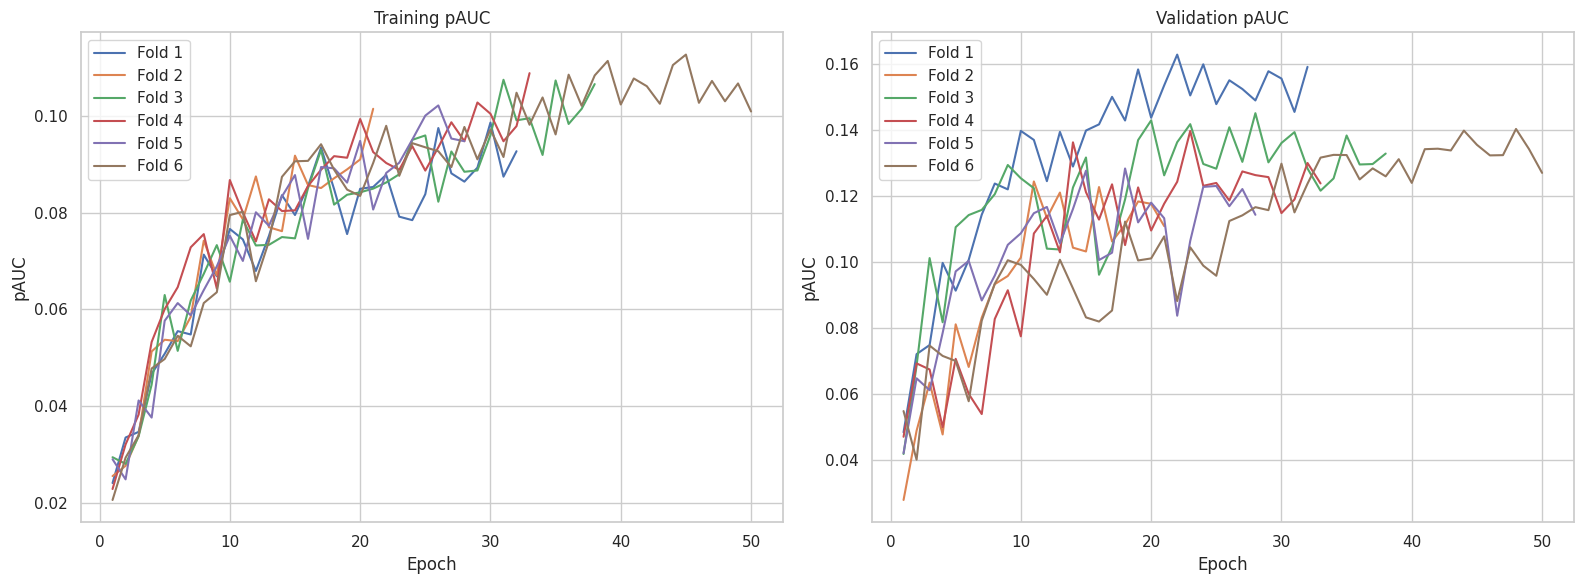

In [14]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.lineplot(x='epoch', y='train_pauc', hue='Fold', data=histories, ax=axes[0])
axes[0].set_title('Training pAUC')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('pAUC')
axes[0].legend(loc='best')

sns.lineplot(x='epoch', y='val_pauc', hue='Fold', data=histories, ax=axes[1])
axes[1].set_title('Validation pAUC')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('pAUC')
axes[1].legend(loc='best')

fig.tight_layout()
plt.show()

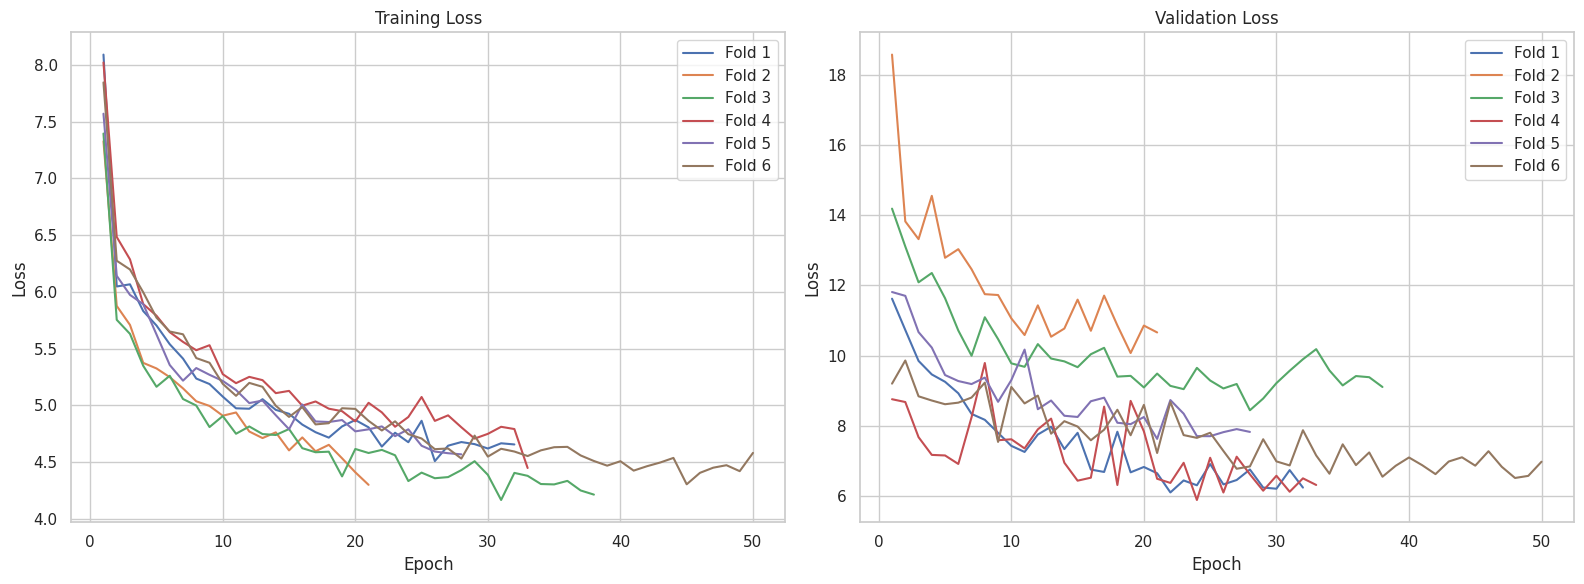

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.lineplot(x='epoch', y='train_loss', hue='Fold', data=histories, ax=axes[0])
axes[0].set_title('Training Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend(loc='best')

sns.lineplot(x='epoch', y='val_loss', hue='Fold', data=histories, ax=axes[1])
axes[1].set_title('Validation Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='best')

fig.tight_layout()
plt.show()